# Classifying EU Sustainability Performance

This project uses the data from the 2025 Europe Sustainable Development Report - the definitive assessment of how EU nations are progressing toward the UN's Sustainable Development Goals (SDGs). This dataset captures the sustainability
performance of 49 European countries across a decade (2015-2024).

The goal is to:

Classify European countries into sustainability performance tiers and identify improvement
pathways.

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading
df = pd.read_csv("../data/eu_sdg_performance_data.csv")

# Data overview
print("Shape:", df.shape)
display(df.head())
print("Columns:", df.columns.tolist())

# Missing value
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(10))

Shape: (420, 19)


,Country,year,sdgi_score,performance_tier,sdg8_income,sdg8_unemp,sdg8_inwork,sdg9_eurd,sdg9_digital,sdg9_bband,sdg16_cpi,sdg16_rsf,sdg16_crime,sdg4_tertiary,sdg4_adult,sdg7_eurenew,sdg13_co2gcp,sdg5_empgap,sdg10_gini
0,Austria,2015,75.3,2,25106.0,6.0,8,3,63.0,82,76,89,13,39,14,33.0,7.73,8.0,27
1,Austria,2016,75.8,2,25533.0,7.0,8,3,63.0,85,75,87,12,40,15,33.0,7.73,8.0,27
2,Austria,2017,76.2,2,25788.0,6.0,8,3,63.0,89,75,87,11,40,16,33.0,7.93,8.0,28
3,Austria,2018,77.0,2,26442.0,5.0,8,3,63.0,89,76,86,10,41,15,34.0,7.55,9.0,27
4,Austria,2019,77.7,2,26740.0,5.0,8,3,63.0,90,77,85,8,42,15,34.0,7.67,9.0,28


Columns: ['Country', 'year', 'sdgi_score', 'performance_tier', 'sdg8_income', 'sdg8_unemp', 'sdg8_inwork', 'sdg9_eurd', 'sdg9_digital', 'sdg9_bband', 'sdg16_cpi', 'sdg16_rsf', 'sdg16_crime', 'sdg4_tertiary', 'sdg4_adult', 'sdg7_eurenew', 'sdg13_co2gcp', 'sdg5_empgap', 'sdg10_gini']

Missing values per column:
sdg7_eurenew     30
sdg5_empgap      10
sdg8_income      10
sdg8_unemp       10
sdg9_digital     10
Country           0
sdg16_rsf         0
sdg13_co2gcp      0
sdg4_adult        0
sdg4_tertiary     0
dtype: int64


The dataset contains 420 observations across 19 variables.
Missing values were identified in five features:
sdg7_eurenew (>7% missing), and sdg5_empgap, sdg8_income, sdg8_unemp, and sdg9_digital (each ~2.4% missing).
Since the missing rate is relatively low, imputation with the median will be applied instead of dropping rows.

In [86]:
# Impute missing columns

cols_with_na = ["sdg7_eurenew", "sdg5_empgap", "sdg8_income", "sdg8_unemp", "sdg9_digital"]

df_imputed = df.copy()
df_imputed["sdg7_eurenew"] = df_imputed["sdg7_eurenew"].fillna(df_imputed.groupby("Country")["sdg7_eurenew"].transform("median"))
df_imputed["sdg5_empgap"] = df_imputed["sdg5_empgap"].fillna(df_imputed.groupby("Country")["sdg5_empgap"].transform("median"))
df_imputed["sdg8_income"] = df_imputed["sdg8_income"].fillna(df_imputed.groupby("Country")["sdg8_income"].transform("median"))
df_imputed["sdg8_unemp"] = df_imputed["sdg8_unemp"].fillna(df_imputed.groupby("Country")["sdg8_unemp"].transform("median"))
df_imputed["sdg9_digital"] = df_imputed["sdg9_digital"].fillna(df_imputed.groupby("Country")["sdg9_digital"].transform("median"))

print("\nMissing values after first imputation:")
print(df_imputed.isnull().sum().sum())

df_imputed["sdg7_eurenew"] = df_imputed["sdg7_eurenew"].fillna(df_imputed["sdg7_eurenew"].median())
df_imputed["sdg5_empgap"] = df_imputed["sdg5_empgap"].fillna(df_imputed["sdg5_empgap"].median())
df_imputed["sdg8_income"] = df_imputed["sdg8_income"].fillna(df_imputed["sdg8_income"].median())
df_imputed["sdg8_unemp"] = df_imputed["sdg8_unemp"].fillna(df_imputed["sdg8_unemp"].median())
df_imputed["sdg9_digital"] = df_imputed["sdg9_digital"].fillna(df_imputed["sdg9_digital"].median())

print("\nMissing values after final imputation:")
print(df_imputed.isnull().sum().sum())


Missing values after first imputation:
70

Missing values after final imputation:
0


**/Target Variable Distribution/**
analyze the distribution of the target variable (`performance_tier`) to check class balance.

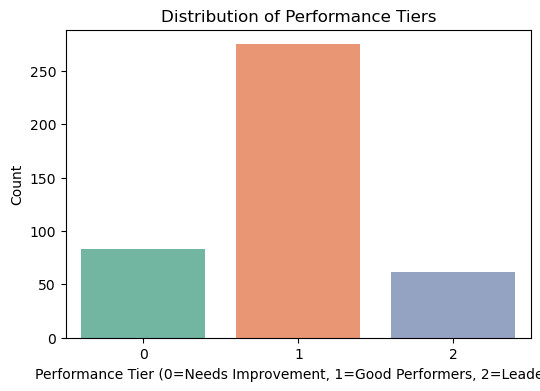

performance_tier
0     83
1    275
2     62
Name: count, dtype: int64


In [87]:
# Distribution of target variable

plt.figure(figsize=(6,4))
sns.countplot(data=df_imputed, x="performance_tier", hue="performance_tier", palette="Set2", legend=False)
plt.title("Distribution of Performance Tiers")
plt.xlabel("Performance Tier (0=Needs Improvement, 1=Good Performers, 2=Leaders)")
plt.ylabel("Count")
plt.savefig('Distribution of Performance Tiers.png')
plt.show()

print(df_imputed.value_counts('performance_tier').sort_index(ascending=True))

The target variable, performance_tier, is imbalanced:
Tier 0 (Needs Improvement): 83 observations,
Tier 1 (Good Performers): 275 observations,
Tier 2 (Leaders): 62 observations.
To address this, models will use class weights or resampling techniques to ensure fair performance across all tiers.
Overall, the dataset provides sufficient information to proceed with feature analysis and model training, though careful handling of imbalance and missing values is required.

**/Feature Preparation/**
separate features into:
- Numerical variables (scaled and median-imputed)
- Categorical variables (imputed with most frequent and one-hot encoded)

In [88]:
# Preparing features
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Features
features = [c for c in df_imputed.columns if c not in ['Country','year','performance_tier','sdgi_score']]

num_feats = [c for c in features if df_imputed[c].dtype in [np.float64, np.int64]]
cat_feats = [c for c in features if c not in num_feats]

num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[('num', num_transformer, num_feats), ('cat', cat_transformer, cat_feats)])
print("All features:")
print(features)

All features:
['sdg8_income', 'sdg8_unemp', 'sdg8_inwork', 'sdg9_eurd', 'sdg9_digital', 'sdg9_bband', 'sdg16_cpi', 'sdg16_rsf', 'sdg16_crime', 'sdg4_tertiary', 'sdg4_adult', 'sdg7_eurenew', 'sdg13_co2gcp', 'sdg5_empgap', 'sdg10_gini']


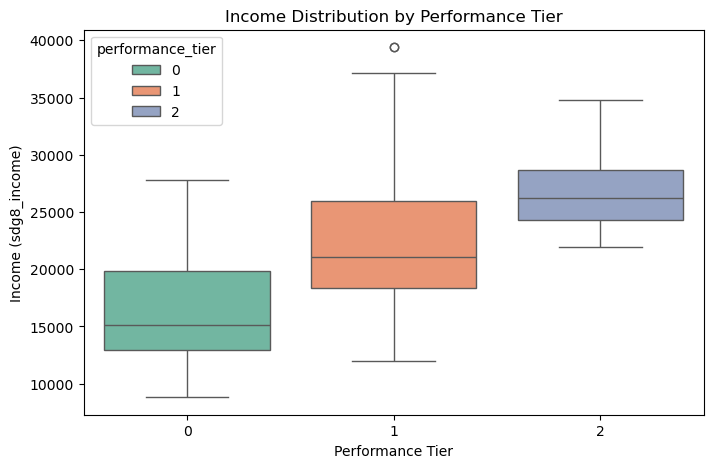

In [89]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_imputed, x="performance_tier", y="sdg8_income", hue="performance_tier", palette="Set2")
plt.title("Income Distribution by Performance Tier")
plt.xlabel("Performance Tier")
plt.ylabel("Income (sdg8_income)")
plt.savefig('Income (sdg8_income).png')
plt.show()

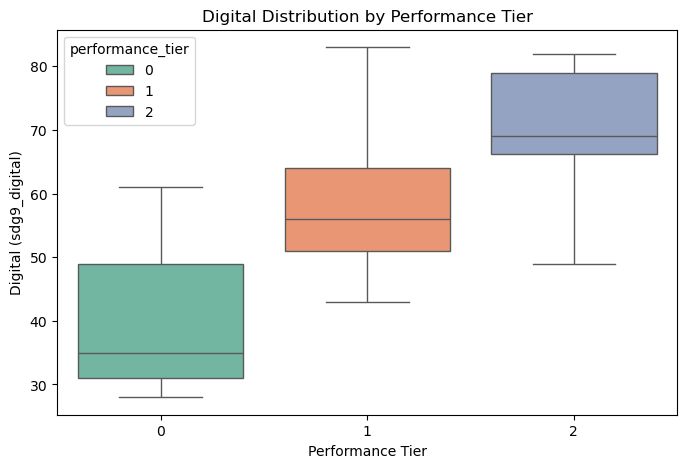

In [90]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_imputed, x="performance_tier", y="sdg9_digital", hue="performance_tier", palette="Set2")
plt.title("Digital Distribution by Performance Tier")
plt.xlabel("Performance Tier")
plt.ylabel("Digital (sdg9_digital)")
plt.savefig('Digital (sdg9_digital).png')
plt.show()

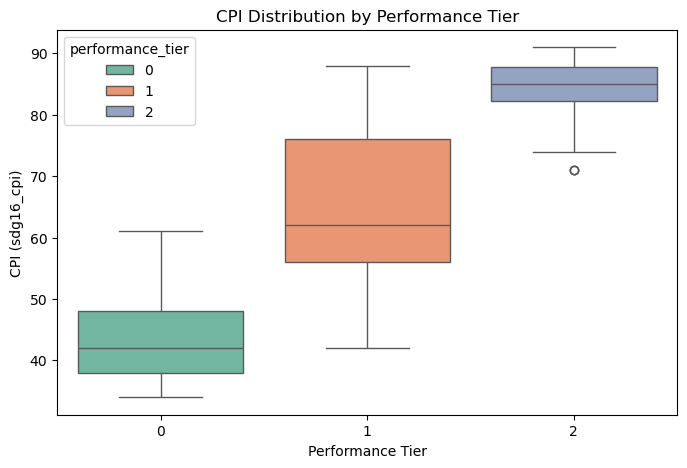

In [91]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_imputed, x="performance_tier", y="sdg16_cpi", hue="performance_tier", palette="Set2")
plt.title("CPI Distribution by Performance Tier")
plt.xlabel("Performance Tier")
plt.ylabel("CPI (sdg16_cpi)")
plt.savefig('CPI (sdg16_cpi).png')
plt.show()

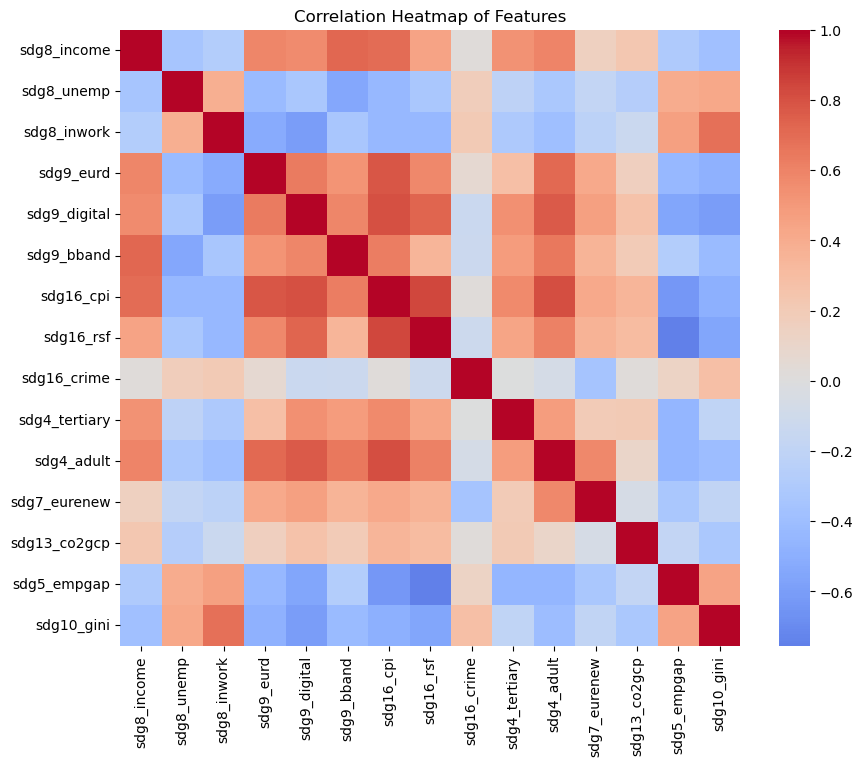

In [92]:
plt.figure(figsize=(10,8))
corr = df_imputed[num_feats].corr()
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap of Features")
plt.savefig('Correlation_heatmap.png')
plt.show()

**/Train-Test Split/**
split the dataset into training (80%) and testing (20%) sets with stratification on the target.

In [93]:
# Train/test split

from sklearn.model_selection import train_test_split
X = df_imputed[features]
y = df_imputed['performance_tier']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

**/Model Training/**
Training three models:
- Logistic Regression
- Random Forest
- Gradient Boosting

In [94]:
# Models: Logistic Regression, Random Forest, Gradient Boosting

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Logistic Regression
pipe_lr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('clf', LogisticRegression(max_iter=1000))])
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

# Random Forest
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('clf', RandomForestClassifier(n_estimators=200, random_state=42))])
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)

# Gradient Boosting
pipe_gb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('clf', GradientBoostingClassifier(n_estimators=200, random_state=42))])
pipe_gb.fit(X_train, y_train)
y_pred_gb = pipe_gb.predict(X_test)

**/Model Evaluation/**
we evaluate models using accuracy, classification report, and normalized confusion matrices.

=== Logistic Regression ===
Accuracy: 0.9285714285714286
              precision    recall  f1-score   support

           0      1.000     0.882     0.938        17
           1      0.902     1.000     0.948        55
           2      1.000     0.667     0.800        12

    accuracy                          0.929        84
   macro avg      0.967     0.850     0.895        84
weighted avg      0.936     0.929     0.925        84



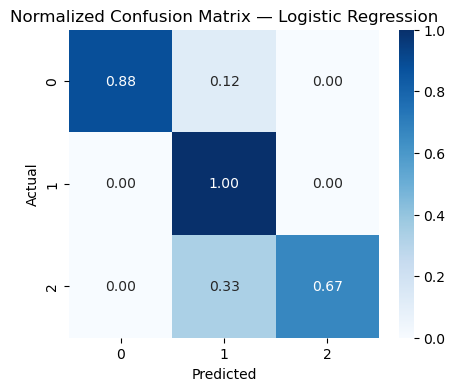

=== Random Forest ===
Accuracy: 0.9761904761904762
              precision    recall  f1-score   support

           0      1.000     0.941     0.970        17
           1      0.965     1.000     0.982        55
           2      1.000     0.917     0.957        12

    accuracy                          0.976        84
   macro avg      0.988     0.953     0.969        84
weighted avg      0.977     0.976     0.976        84



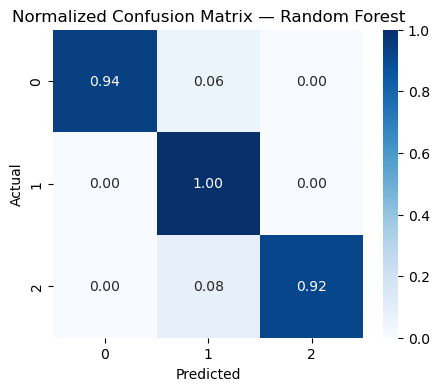

=== Gradient Boosting ===
Accuracy: 0.9880952380952381
              precision    recall  f1-score   support

           0      1.000     0.941     0.970        17
           1      0.982     1.000     0.991        55
           2      1.000     1.000     1.000        12

    accuracy                          0.988        84
   macro avg      0.994     0.980     0.987        84
weighted avg      0.988     0.988     0.988        84



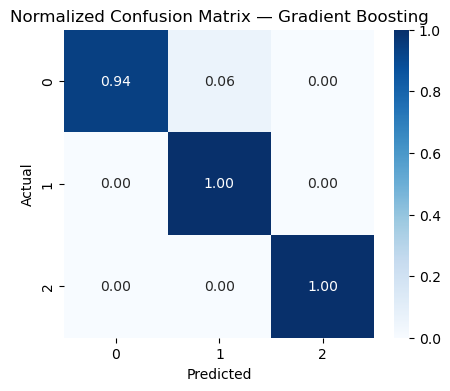

In [95]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

# Evaluation function
def print_eval(y_true, y_pred, name):
    print(f"=== {name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues")
    plt.title(f"Normalized Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig('Normalized Confusion Matrix.png')
    plt.show()

print_eval(y_test, y_pred_lr, "Logistic Regression")
print_eval(y_test, y_pred_rf, "Random Forest")
print_eval(y_test, y_pred_gb, "Gradient Boosting")

**/Feature Importance/**
we analyze which features drive model predictions using:
- Permutation importance (RF)
- Tree-based feature importances (RF, GB)
- Coefficients (LR)

In [96]:
# Permutation importance for Random Forest
print("Permutation importance (Random Forest):")
res = permutation_importance(pipe_rf, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)

# Feature names after preprocessing
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    num_names = num_feats
    cat_names = pipe_rf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_feats).tolist()
    feature_names = np.concatenate([num_names, cat_names])

perm_imp = pd.Series(res.importances_mean, index=feature_names).sort_values(ascending=False)
display(perm_imp.head(10))

# Feature importances from tree models (RF and GB) and coefficients for LR
def model_importances(pipe, model_name, top_n=10):
    if hasattr(pipe.named_steps['clf'], "feature_importances_"):
        # For tree-based models
        fi = pipe.named_steps['clf'].feature_importances_
    else:
        # For linear models like Logistic Regression
        fi = np.mean(np.abs(pipe.named_steps['clf'].coef_), axis=0)
    
    # Get feature names
    try:
        fnames = preprocessor.get_feature_names_out()
    except:
        num_names = num_feats
        cat_names = pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_feats).tolist()
        fnames = np.concatenate([num_names, cat_names])
    
    s = pd.Series(fi, index=fnames).sort_values(ascending=False).head(top_n)
    print(f"Top {top_n} features — {model_name}:")
    display(s)
    return s

# Run for all models
lr_top = model_importances(pipe_lr, "Logistic Regression", top_n=10)
rf_top = model_importances(pipe_rf, "Random Forest", top_n=10)
gb_top = model_importances(pipe_gb, "Gradient Boosting", top_n=10)

Permutation importance (Random Forest):


num__sdg9_digital     0.084921
num__sdg7_eurenew     0.040079
num__sdg9_eurd        0.027778
num__sdg16_rsf        0.023016
num__sdg4_tertiary    0.020238
num__sdg16_cpi        0.011905
num__sdg10_gini       0.010317
num__sdg8_income      0.009524
num__sdg5_empgap      0.009127
num__sdg8_inwork      0.000000
dtype: float64

Top 10 features — Logistic Regression:


num__sdg9_digital     1.161513
num__sdg16_cpi        1.042273
num__sdg4_tertiary    0.916208
num__sdg16_rsf        0.767848
num__sdg10_gini       0.742390
num__sdg7_eurenew     0.725476
num__sdg8_income      0.716133
num__sdg9_eurd        0.711009
num__sdg16_crime      0.607910
num__sdg5_empgap      0.590003
dtype: float64

Top 10 features — Random Forest:


num__sdg9_digital     0.174330
num__sdg16_cpi        0.143685
num__sdg4_adult       0.086225
num__sdg7_eurenew     0.080202
num__sdg16_rsf        0.078892
num__sdg10_gini       0.070413
num__sdg5_empgap      0.061035
num__sdg8_income      0.060118
num__sdg9_eurd        0.051578
num__sdg4_tertiary    0.050285
dtype: float64

Top 10 features — Gradient Boosting:


num__sdg9_digital     0.362971
num__sdg16_cpi        0.159478
num__sdg7_eurenew     0.117935
num__sdg4_tertiary    0.062437
num__sdg9_eurd        0.059899
num__sdg9_bband       0.038445
num__sdg10_gini       0.038092
num__sdg4_adult       0.037619
num__sdg5_empgap      0.036299
num__sdg8_income      0.031593
dtype: float64

**/Tier Profiles/**
we calculate average feature values for each performance tier to understand the differences between Tier 0, 1, and 2.

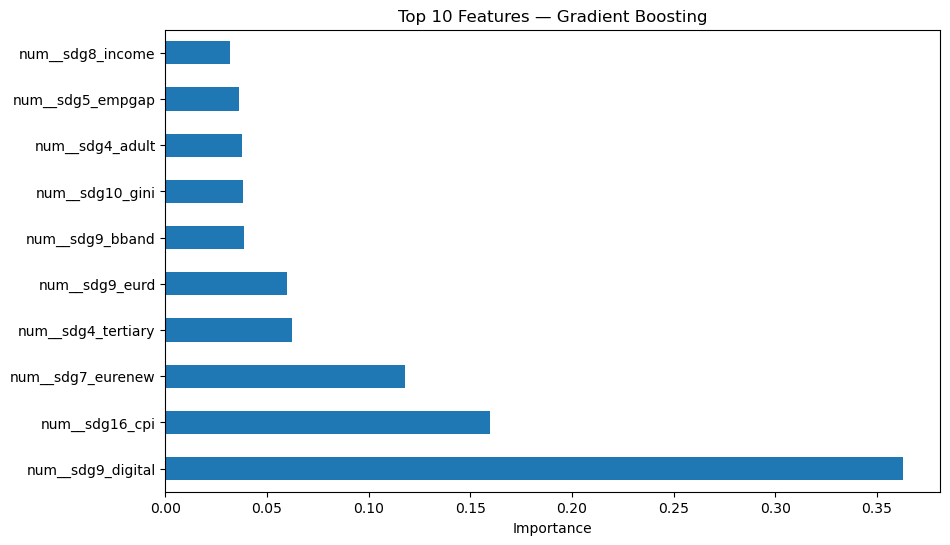

In [97]:
plt.figure(figsize=(10,6))
gb_top.plot(kind="barh")
plt.title("Top 10 Features — Gradient Boosting")
plt.xlabel("Importance")
plt.savefig('Top_10_Features.png')
plt.show()

In [98]:
tier_profiles = df_imputed.groupby("performance_tier")[features].mean()
display(tier_profiles)

,sdg8_income,sdg8_unemp,sdg8_inwork,sdg9_eurd,sdg9_digital,sdg9_bband,sdg16_cpi,sdg16_rsf,sdg16_crime,sdg4_tertiary,sdg4_adult,sdg7_eurenew,sdg13_co2gcp,sdg5_empgap,sdg10_gini
performance_tier,,,,,,,,,,,,,,,
0,16150.144578,10.963855,10.746988,0.771084,37.602410,80.759036,44.240964,65.867470,11.120482,37.927711,4.867470,21.469880,5.344819,19.650602,35.361446
1,22309.334545,6.807273,8.214545,1.672727,58.970909,89.578182,65.214545,79.785455,9.487273,43.403636,12.665455,24.807273,6.583164,9.658182,29.512727
2,26722.306452,6.193548,6.129032,2.887097,69.790323,94.177419,83.951613,89.048387,8.532258,45.500000,24.419355,47.080645,6.181129,5.370968,27.241935


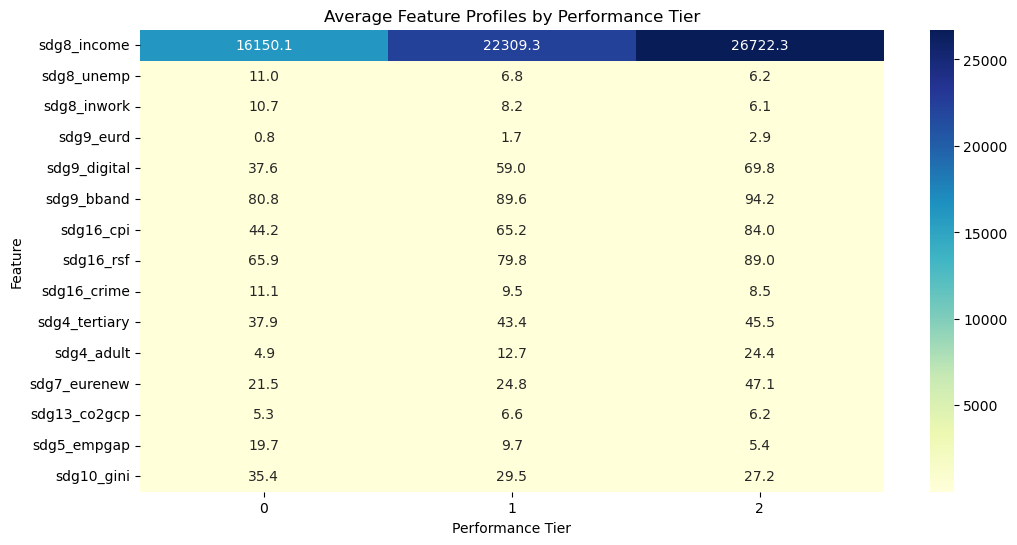

In [99]:
plt.figure(figsize=(12,6))
sns.heatmap(tier_profiles.T, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title("Average Feature Profiles by Performance Tier")
plt.xlabel("Performance Tier")
plt.ylabel("Feature")
plt.savefig('Average Feature Profiles.png')
plt.show()

- Tier 0: Lower income, weak digital adoption, higher unemployment.  
- Tier 1: Moderate values across most indicators.  
- Tier 2: High income, advanced digital adoption, strong governance and education levels.  

**Conclusion:**
The progression from Tier 0 to Tier 2 clearly reflects socio-economic development, digital transformation, and institutional quality.